In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
from scipy.optimize import least_squares

warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)
BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

c = 299792458

## Frequency Response

Text(0.5, 0, 'Frequency [mH')

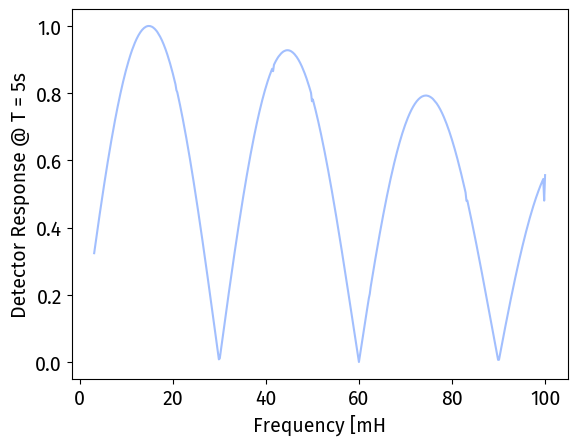

In [2]:
d = 1e10
c = 3e8


def h(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 


def signal(t0,T=160,H= 1e-20,f = 1/160,phi = 0, theta = np.pi/2, pol = 0):
    
    ts = np.linspace(t0,t0+T,10000)
    dt = ts[1]-ts[0]
    s = (1+np.cos(theta))/2*(h(ts,H,f,phi)-h(ts+d*(1-np.cos(theta))/c,H,f,phi))
    s_bar = np.sum((1/T * s*dt))
    return s_bar




fs = np.linspace(1/320,0.1,500)
ts = np.linspace(0,1000,500)
signal_max = []
for f in fs: 
    signals = []
    for t in ts:
        signal_amp = signal(t,f = f,T = 5)
        signals.append(signal_amp)
    # plt.plot(ts,signals)
    signal_max.append(max(signals))


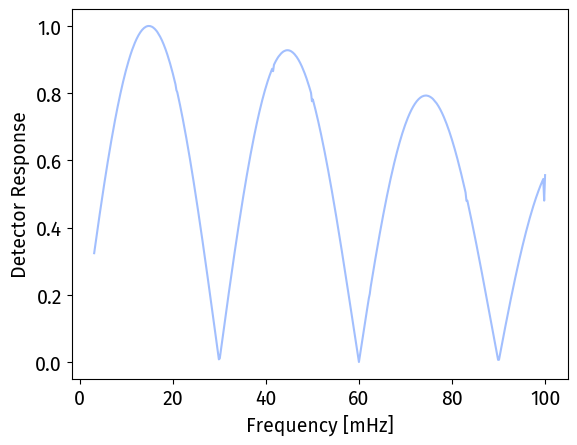

In [6]:

plt.plot(fs*1000,signal_max/max(signal_max))
plt.ylabel('Detector Response')
plt.xlabel('Frequency [mHz]')
plt.savefig('frequency_response.pdf')

## Antenna Pattern

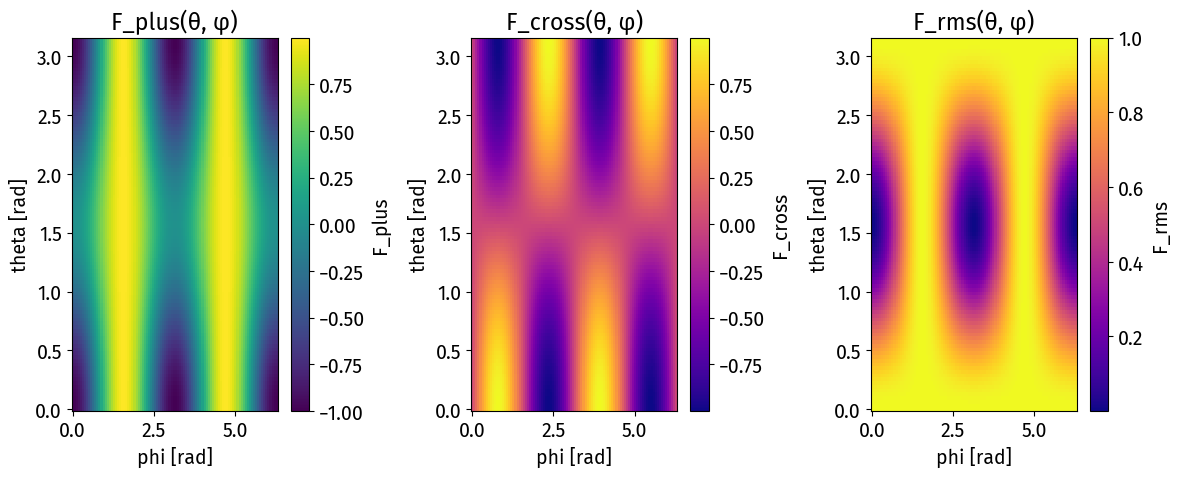

In [8]:
phi = np.linspace(0, 2*np.pi, 100)
theta = np.linspace(0, np.pi, 100)
Phi, Theta = np.meshgrid(phi, theta)  # Create 2D grid

# Compute F_plus and F_cross
F_plus = np.sin(Phi)**2 - np.cos(Phi)**2 * np.cos(Theta)**2
F_cross = 2*np.sin(Phi) * np.cos(Phi) * np.cos(Theta)

F_rms = np.sqrt(F_plus**2+F_cross**2)
# Plot F_plus
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.pcolormesh(Phi, Theta, F_plus, shading='auto', cmap='viridis')
plt.colorbar(label='F_plus')
plt.xlabel('phi [rad]')
plt.ylabel('theta [rad]')
plt.title('F_plus(θ, φ)')

# Plot F_cross
plt.subplot(1,3,2)
plt.pcolormesh(Phi, Theta, F_cross, shading='auto', cmap='plasma')
plt.colorbar(label='F_cross')
plt.xlabel('phi [rad]')
plt.ylabel('theta [rad]')
plt.title('F_cross(θ, φ)')


plt.subplot(1,3,3)
plt.pcolormesh(Phi, Theta, F_rms, shading='auto', cmap='plasma')
plt.colorbar(label='F_rms')
plt.xlabel('phi [rad]')
plt.ylabel('theta [rad]')
plt.title('F_rms(θ, φ)')

plt.tight_layout()

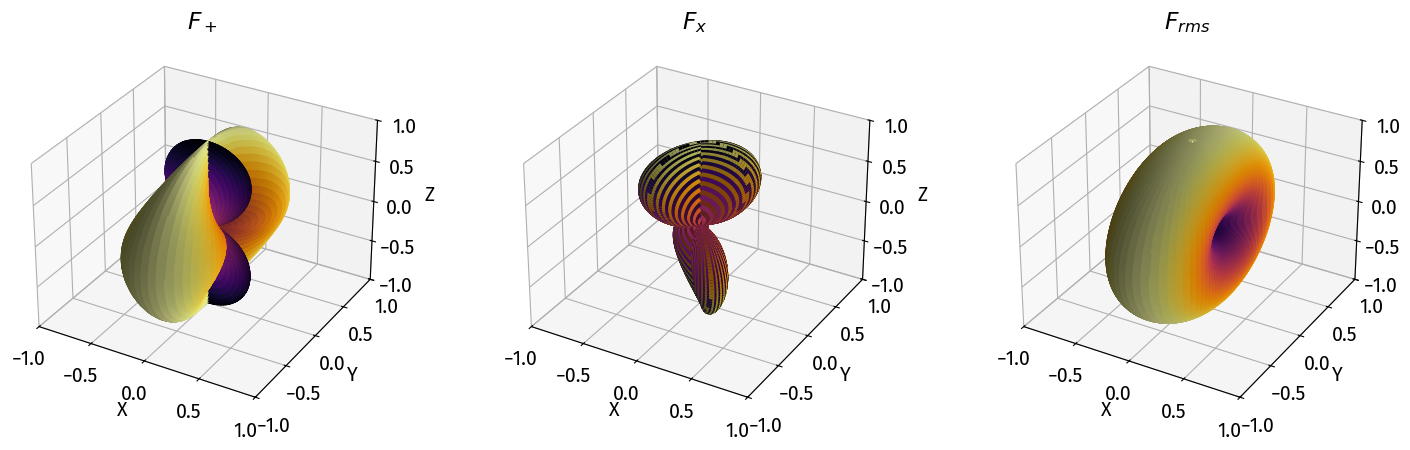

In [16]:
def spherical_to_cartesian(F):
    X = F * np.sin(Theta) * np.cos(Phi)
    Y = F * np.sin(Theta) * np.sin(Phi)
    Z = F * np.cos(Theta)
    return X, Y, Z

def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres look spherical."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Compute global min and max for axis limits
X_plus, Y_plus, Z_plus = spherical_to_cartesian(F_plus)
X_cross, Y_cross, Z_cross = spherical_to_cartesian(F_cross)
X_rms, Y_rms, Z_rms = spherical_to_cartesian(F_rms)


# Plot all three 3D surfaces
fig = plt.figure(figsize=(18,5))

# F_plus
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_plus, Y_plus, Z_plus, facecolors=plt.cm.inferno((F_plus - F_plus.min()) / (F_plus.max() - F_plus.min())),
                 rstride=1, cstride=1, antialiased=True)
ax1.set_title('$F_+$')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)

# F_cross
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_cross, Y_cross, Z_cross, facecolors=plt.cm.inferno((F_cross - F_cross.min()) / (F_cross.max() - F_cross.min())),
                 rstride=1, cstride=1, antialiased=True)
ax2.set_title('$F_x$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_zlim(-1, 1)

# F_rms
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_rms, Y_rms, Z_rms, facecolors=plt.cm.inferno((F_rms - F_rms.min()) / (F_rms.max() - F_rms.min())),
                 rstride=1, cstride=1, antialiased=True)
ax3.set_title('$F_{rms}$')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_xlim(-1, 1)
ax3.set_ylim(-1, 1)
ax3.set_zlim(-1, 1)

set_axes_equal(ax1)
set_axes_equal(ax2)
set_axes_equal(ax3)


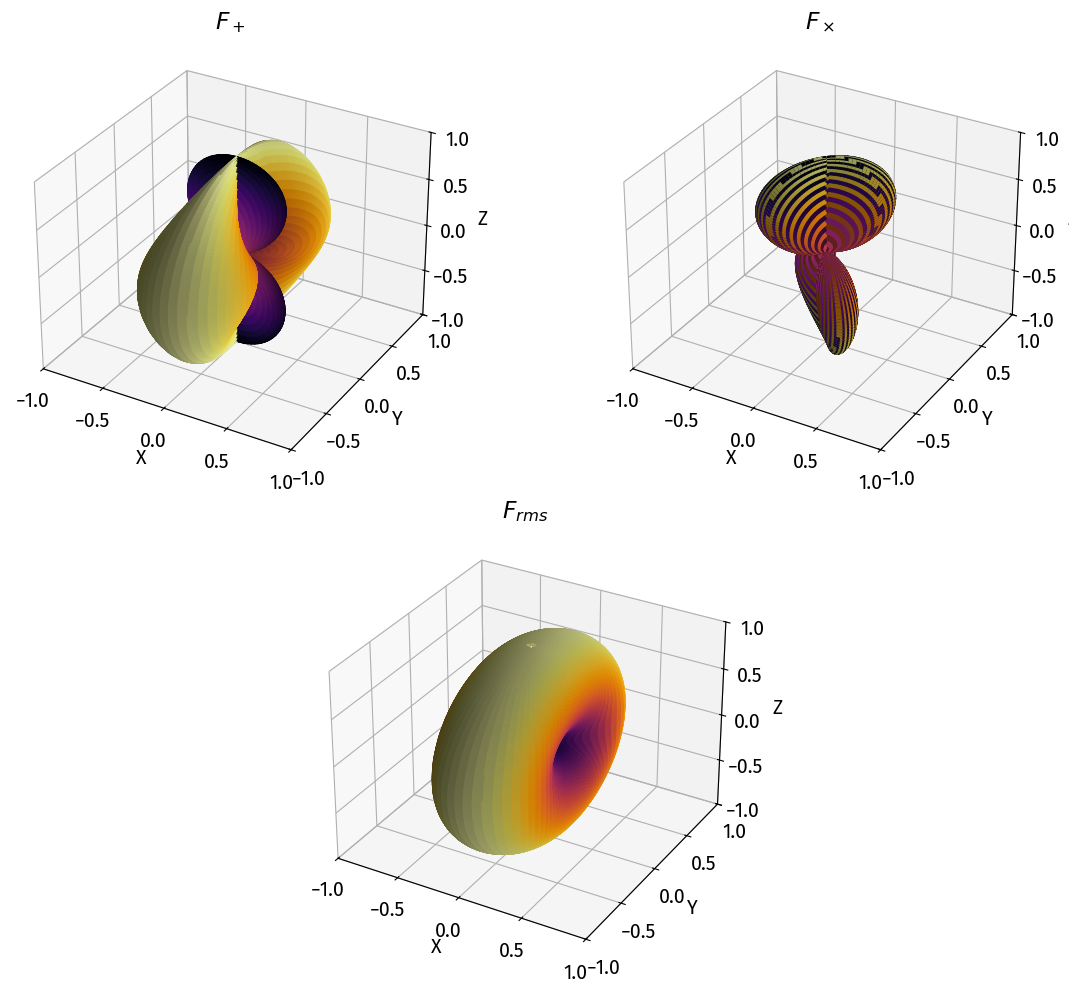

In [17]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create figure with GridSpec (2 rows, 2 cols)
fig = plt.figure(figsize=(12,10))
gs = GridSpec(2, 2, figure=fig)

# Top-left: F_plus
ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax1.plot_surface(X_plus, Y_plus, Z_plus, 
                 facecolors=plt.cm.inferno((F_plus - F_plus.min()) / (F_plus.max() - F_plus.min())),
                 rstride=1, cstride=1, antialiased=True)
ax1.set_title('$F_+$')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)

# Top-right: F_cross
ax2 = fig.add_subplot(gs[0,1], projection='3d')
ax2.plot_surface(X_cross, Y_cross, Z_cross, 
                 facecolors=plt.cm.inferno((F_cross - F_cross.min()) / (F_cross.max() - F_cross.min())),
                 rstride=1, cstride=1, antialiased=True)
ax2.set_title('$F_\\times$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_zlim(-1, 1)

# Bottom spanning both columns: F_rms
ax3 = fig.add_subplot(gs[1,:], projection='3d')
ax3.plot_surface(X_rms, Y_rms, Z_rms, 
                 facecolors=plt.cm.inferno((F_rms - F_rms.min()) / (F_rms.max() - F_rms.min())),
                 rstride=1, cstride=1, antialiased=True)
ax3.set_title('$F_{rms}$')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_xlim(-1, 1)
ax3.set_ylim(-1, 1)
ax3.set_zlim(-1, 1)

plt.tight_layout()
plt.savefig("antenna_patterns.png", dpi=300)  # save high-res
plt.show()

## Detector Network Response

In [5]:
def compute_complex_response(positions, arms, f_gw, A_plus, A_cross, theta, phi_sky, psi=0, phi_cross=0):
    # GW propagation vector

    
    k = np.array([np.sin(theta)*np.cos(phi_sky), np.sin(theta)*np.sin(phi_sky), np.cos(theta)])
    
    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)
    
    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)
    
    # Rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
    
    # Detector tensors
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)
    
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
    
    tau = np.dot(positions, k)/c

    # Complex response including time delay
    S = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*phi_cross)) * np.exp(-1j*2*np.pi*f_gw*tau)
    return S




In [6]:
def detector_response_vec(theta, phi, psi, arms, pol_ampls, positions, f_gw, A0=1.0):
    """
    Return model vector m_d (complex) for each detector, given overall amplitude A0.
    - pol_ampls: dict with 'Aplus' and 'Across' (can be real or complex)
    - arms: (n_det,3)
    - positions: (n_det,3)
    - returns: m (n_det,) complex
    """
    k = np.array([np.sin(theta)*np.cos(phi),
                  np.sin(theta)*np.sin(phi),
                  np.cos(theta)])
    # build transverse basis (safe choice)
    # pick an arbitrary reference not parallel to k
    ref = np.array([0.0, 0.0, 1.0])
    if np.allclose(np.abs(np.dot(ref, k)), 1.0):
        ref = np.array([0.0, 1.0, 0.0])
    ex = np.cross(ref, k)
    ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)

    e_plus  = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)

    # rotate by psi
    e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
    e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)

    # detector tensors for one-arm (d^i d^j)/2
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)

    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)

    # intrinsic (polarization) combination (no global scale yet)
    pol_combo = F_plus * pol_ampls['Aplus'] + F_cross * pol_ampls['Across']  # (n_det,)

    # geometric phase factor from travel time
    delays = np.dot(positions, k) / c   # seconds
    phases = np.exp(-2j * np.pi * f_gw * delays)

    # final model vector (include overall amplitude A0)
    m = A0 * pol_combo * phases
    return m


def profile_likelihood_over_A0(observed, obs_sigma, theta, phi, psi,
                               arms, pol_ampls, positions, f_gw):
    """
    Profile (fit) the complex overall amplitude A0 that minimizes chi2,
    and return A_hat and the log-likelihood (up to additive const).
    - observed: complex array (n_det,)
    - obs_sigma: real positive array (n_det,) standard deviations (same for real & imag)
    """
    # model with A0 = 1
    m = detector_response_vec(theta, phi, psi, arms, pol_ampls, positions, f_gw, A0=1.0)

    w = 1.0 / (obs_sigma**2)   # weights
    # weighted inner products (note conjugation on m)
    num = np.sum(w * np.conjugate(m) * observed)    # scalar complex
    den = np.sum(w * np.conjugate(m) * m)           # scalar real>=0 (if noise real)
    if np.abs(den) < 1e-30:
        # model is (nearly) zero everywhere -> cannot fit amplitude
        A_hat = 0.0 + 0.0j
        chi2 = np.sum(w * np.abs(observed)**2)
    else:
        A_hat = num / den
        resid = observed - A_hat * m
        chi2 = np.sum(w * np.abs(resid)**2)

    logL = -0.5 * chi2
    return A_hat, logL

Best-fit complex A0: (1+0j)
Profile log-likelihood: -0.0


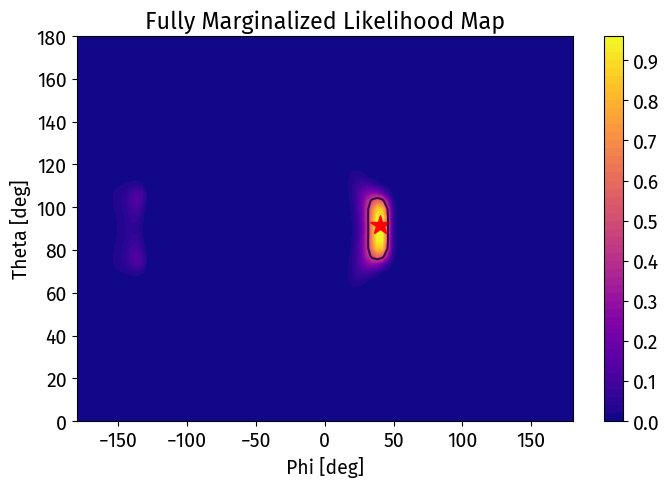

In [18]:
theta_1 = 0
theta_2 = np.pi/3
theta_3 = np.pi/6
r = 1.46e11 
positions = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0],[r*np.cos(theta_2),r*np.sin(theta_2),0],[r*np.cos(theta_3),r*np.sin(theta_3),0]])
arms = np.array([[np.sin(theta_1),np.cos(theta_1),0],[np.sin(theta_2),np.cos(theta_2),0],[np.sin(theta_3),np.cos(theta_3),0]])
f_gw = 1e-3
A_plus  = 1
A_cross = 0
theta_sky  = 1.6
phi_sky  = 0.7
psi  =0 
phi_cross = 0

S = compute_complex_response(positions, arms, f_gw, A_plus, A_cross, theta_sky, phi_sky)


pol_ampls = {'Aplus': 1.0, 'Across': 0.0}   # only plus intrinsic

# fake observed complex amplitudes (from matched-filter / analytic extraction)
obs_sigma = np.array([0.03, 0.03, 0.03])
psi = 0


A_hat, logL = profile_likelihood_over_A0(S, obs_sigma, theta_sky, phi_sky, psi,
                                         arms, pol_ampls, positions, f_gw)
print("Best-fit complex A0:", A_hat)
print("Profile log-likelihood:", logL)


theta_vals = np.linspace(0, np.pi, 50)
phi_vals = np.linspace(-np.pi, np.pi, 100)

likelihood = np.zeros((len(theta_vals), len(phi_vals)))


for i, theta in enumerate(theta_vals):
        for j, phi in enumerate(phi_vals):
            A_hat, logL = profile_likelihood_over_A0(S, obs_sigma, theta, phi, psi,
                                         arms, pol_ampls, positions, f_gw)
            likelihood[i,j] =  np.exp(logL)


plt.figure(figsize=(8,5))
plt.contourf(phi_vals*180/np.pi, theta_vals*180/np.pi, likelihood, 50, cmap='plasma')


plt.xlabel("Phi [deg]")
plt.ylabel("Theta [deg]")
plt.title("Fully Marginalized Likelihood Map")

plt.plot(phi_sky*180/np.pi, theta_sky*180/np.pi, marker='*', markersize=15, color='red', label='true_location')

plt.colorbar()

plt.contour(phi_vals*180/np.pi, theta_vals*180/np.pi, likelihood, levels=[np.max(likelihood)-0.5])

np.float64(-0.553173587045175)

In [8]:
sky_map_mollweide(likelihood, theta_vals, phi_vals)


NameError: name 'sky_map_mollweide' is not defined

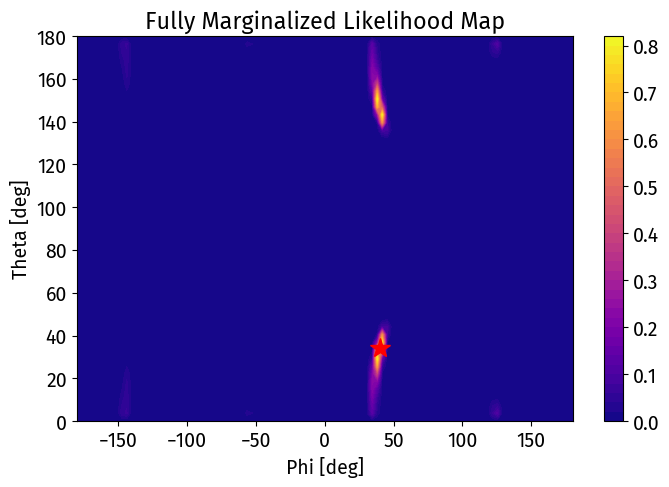

In [306]:
def marginalized_likelihood_map(positions, arms, f_gw, S_measured,
                                theta_vals=None, phi_vals=None):
    """
    Compute a fully marginalized likelihood over ψ, A+, A×, φ_cross
    for each grid point (theta, phi) using least-squares fit.

    Returns a chi2 map and plots it.
    """
    if theta_vals is None:
        theta_vals = np.linspace(0, np.pi, 50)
    if phi_vals is None:
        phi_vals = np.linspace(-np.pi, np.pi, 100)
    
    positions = np.atleast_2d(positions)
    arms = np.atleast_2d(arms)
    S_measured = np.asarray(S_measured, dtype=complex)
    
    Nd = len(positions)
    chi2 = np.zeros((len(theta_vals), len(phi_vals)))
    
    for i, theta in enumerate(theta_vals):
        for j, phi in enumerate(phi_vals):
            # Propagation vector
            k_vec = np.array([np.sin(theta)*np.cos(phi),
                              np.sin(theta)*np.sin(phi),
                              np.cos(theta)])
            
            # Polarization basis
            if np.allclose(k_vec,[0,0,1]):
                ex = np.array([1,0,0])
            else:
                ex = np.cross([0,0,1], k_vec)
                ex /= np.linalg.norm(ex)
            ey = np.cross(k_vec, ex)
            
            e_plus = np.outer(ex, ex) - np.outer(ey, ey)
            e_cross = np.outer(ex, ey) + np.outer(ey, ex)
            
            D = 0.5 * np.einsum('di,dj->dij', arms, arms)
            
            # Objective function: difference between model and measured amplitudes
            def obj(params):
                psi, A_plus, A_cross, phi_cross = params
                e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
                e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
                F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
                F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
                tau = np.dot(positions, k_vec)/299792458
                S_model = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*phi_cross)) * np.exp(-1j*2*np.pi*f_gw*tau)
                return np.concatenate([S_model.real - S_measured.real,
                                       S_model.imag - S_measured.imag])
            
            # Initial guess: psi=0, A+ max amplitude, A_cross=0, phi_cross=0
            amp_guess = np.max(np.abs(S_measured))
            x0 = [0.0, amp_guess, 0.0, 0.0]
            bounds = ([0,0,0,-np.pi],[np.pi,10*amp_guess,10*amp_guess,np.pi])
            
            res = least_squares(obj, x0, bounds=bounds)
            
            # Compute minimized chi2 for this grid point
            chi2[i,j] = np.sum(res.fun**2)
    
    # Plot the marginalized likelihood map
    plt.figure(figsize=(8,5))
    plt.contourf(phi_vals*180/np.pi, theta_vals*180/np.pi, chi2, 50, cmap='plasma')
    plt.xlabel("Phi [deg]")
    plt.ylabel("Theta [deg]")
    plt.title("Fully Marginalized Likelihood Map")
    plt.colorbar(label="Chi² (minimized over ψ, A+, A×, φ_cross)")
    plt.show()
    
    return chi2

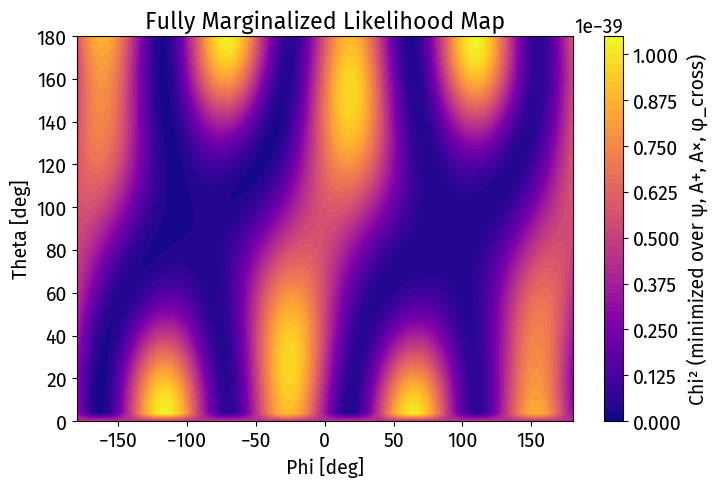

In [307]:
chi2_map = marginalized_likelihood_map(positions, arms, f_gw, S_measured)


In [72]:
def sky_map_mollweide(chi2, theta_vals, phi_vals):
    """
    Plot a marginalized likelihood map on a Mollweide projection.
    
    Parameters
    ----------
    chi2 : 2D array
        Chi-squared values (lower = better fit).
    theta_vals : 1D array
        Theta (polar) grid values in radians.
    phi_vals : 1D array
        Phi (azimuthal) grid values in radians.
    """
    # Convert theta -> declination
    dec = np.pi/2 - theta_vals[:, np.newaxis]  # shape (Ntheta,1)
    phi_grid, dec_grid = np.meshgrid(phi_vals, dec[:,0])
    
    # Mollweide expects longitude from -pi to pi
    phi_grid_wrap = phi_grid.copy()
    
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111, projection='mollweide')
    
    # Normalize chi2 for plotting
    chi2_norm = (chi2 - np.min(chi2)) / (np.max(chi2) - np.min(chi2))
    
    im = ax.pcolormesh(phi_grid_wrap, dec_grid, chi2_norm, cmap='plasma', shading='auto')
    plt.grid(True)
    plt.title("Fully Marginalized Likelihood Map (Mollweide)")
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
    cbar.set_label("Normalized Chi²")
    plt.show()

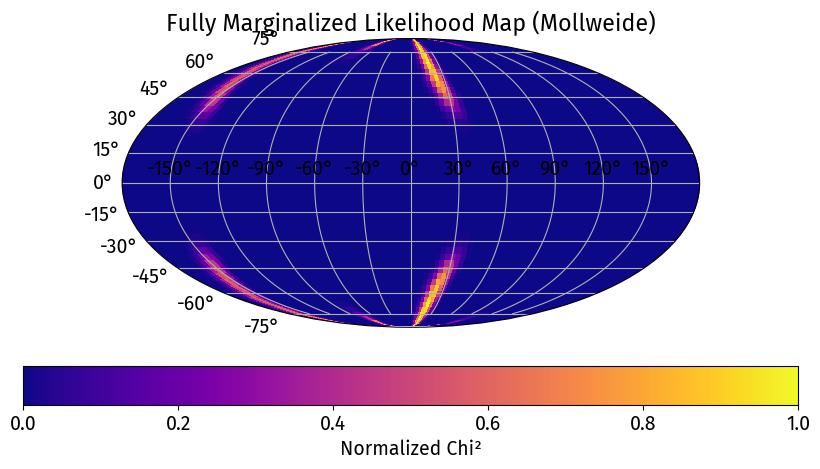

In [73]:
# theta_vals = np.linspace(0, np.pi, 50)
# phi_vals   = np.linspace(-np.pi, np.pi, 100)



In [ ]:
def one_arm_detector_response_vec(
    t, positions, arms, f_gw, A_plus, A_cross, theta, phi_sky, psi=0, phi_cross=0
):
    """
    Vectorized response of one-arm detectors to a monochromatic GW,
    including a phase difference between plus and cross polarizations.

    Parameters
    ----------
    t : array_like, shape (Nt,)
        Times at which to evaluate the signals.
    positions : array_like, shape (Nd, 3)
        Cartesian coordinates of each detector (meters).
    arms : array_like, shape (Nd, 3)
        Unit vectors along each detector's arm.
    f_gw : float
        GW frequency in Hz.
    A_plus : float
        Amplitude of plus polarization.
    A_cross : float
        Amplitude of cross polarization.
    theta : float
        GW propagation polar angle (from z-axis) in radians.
    phi_sky : float
        GW propagation azimuthal angle (from x-axis) in radians.
    psi : float
        Polarization angle in radians (default 0).
    phi_cross : float
        Phase difference of cross polarization relative to plus (radians, default 0).

    Returns
    -------
    signals : ndarray, shape (Nd, Nt)
        Response of each detector at each time.
    """

    c = 299792458  # speed of light in m/s

    positions = np.atleast_2d(positions)
    arms = np.atleast_2d(arms)
    t = np.atleast_1d(t)

    Nd = positions.shape[0]
    Nt = t.size

    # GW propagation unit vector
    k = np.array([
        np.sin(theta) * np.cos(phi_sky),
        np.sin(theta) * np.sin(phi_sky),
        np.cos(theta)
    ])

    # Basis vectors perpendicular to k
    if np.allclose(k, [0,0,1]):
        ex = np.array([1,0,0])
    else:
        ex = np.cross([0,0,1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)

    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)

    # Rotate by polarization angle psi
    e_plus_rot =  e_plus * np.cos(2*psi) + e_cross * np.sin(2*psi)
    e_cross_rot = -e_plus * np.sin(2*psi) + e_cross * np.cos(2*psi)

    # Detector tensors for one-arm detectors: D = 0.5 * u ⊗ u
    D = 0.5 * np.einsum('di,dj->dij', arms, arms)  # shape (Nd,3,3)

    # Antenna pattern projections
    F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)   # shape (Nd,)
    F_cross = np.einsum('dij,ij->d', D, e_cross_rot)  # shape (Nd,)

    # Time delays for each detector
    tau = np.dot(positions, k) / c  # shape (Nd,)
 


    # Expand dimensions for broadcasting over time
    t_mat = t[None, :]  # shape (1, Nt)
    tau_mat = tau[:, None]  # shape (Nd, 1)
    # Compute signals
    signals = (
        F_plus[:, None]  * A_plus  * np.cos(2*np.pi*f_gw*(t_mat - tau_mat)) +
        F_cross[:, None] * A_cross * np.cos(2*np.pi*f_gw*(t_mat - tau_mat) + phi_cross)
    )

    return signals






def estimate_gw_parameters(positions, arms, f_gw, S_measured):
    """
    Estimate sky location, polarization, and amplitudes of a monochromatic GW.
    
    Parameters
    ----------
    positions : (Nd,3) array
        Detector positions.
    arms : (Nd,3) array
        Unit vectors along detector arms.
    f_gw : float
        GW frequency in Hz.
    S_measured : (Nd,) complex array
        Measured complex response (amplitude + phase) at each detector.
    
    Returns
    -------
    result : dict
        Estimated parameters: theta, phi, psi, A_plus, A_cross, phi_cross
    """
    c = 299792458
    positions = np.atleast_2d(positions)
    arms = np.atleast_2d(arms)
    S_measured = np.asarray(S_measured, dtype=complex)
    
    Nd = len(positions)
    
    def model(params):
        theta, phi, psi, A_plus, A_cross, phi_cross = params
        k = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        
        # Polarization basis
        if np.allclose(k,[0,0,1]):
            ex = np.array([1,0,0])
        else:
            ex = np.cross([0,0,1], k)
            ex /= np.linalg.norm(ex)
        ey = np.cross(k, ex)
        
        e_plus = np.outer(ex,ex) - np.outer(ey,ey)
        e_cross = np.outer(ex,ey) + np.outer(ey,ex)
        
        e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
        e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
        
        D = 0.5 * np.einsum('di,dj->dij', arms, arms)
        F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
        F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
        
        tau = np.dot(positions, k)/c
        S_model = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*phi_cross)) * np.exp(-1j*2*np.pi*f_gw*tau)
        return np.concatenate([S_model.real - S_measured.real, S_model.imag - S_measured.imag])
    
    # Initial guess: theta=pi/4, phi=pi/4, psi=0, A_plus=max amplitude, A_cross=0, phi_cross=0
    amp_guess = np.max(np.abs(S_measured))
    x0 = [np.pi/4, np.pi/4, 0.0, amp_guess, 0.0, 0.0]
    
    # Bounds: theta [0,pi], phi [-pi,pi], psi [0,pi], A_plus,A_cross >0, phi_cross [-pi,pi]
    bounds = ([0,-np.pi,0,0,0,-np.pi], [np.pi,np.pi,np.pi,10*amp_guess,10*amp_guess,np.pi])
    
    res = least_squares(model, x0, bounds=bounds, method='trf')
    
    theta_est, phi_est, psi_est, A_plus_est, A_cross_est, phi_cross_est = res.x
    return {
        'theta': theta_est,
        'phi': phi_est,
        'psi': psi_est,
        'A_plus': A_plus_est,
        'A_cross': A_cross_est,
        'phi_cross': phi_cross_est
    }

import numpy as np
from scipy.optimize import least_squares

def estimate_gw_two_step(positions, arms, f_gw, S_measured):
    """
    Two-step robust GW parameter estimation:
    1) Sky location (theta, phi) from measured phases
    2) Polarization and amplitudes from measured amplitudes

    Parameters
    ----------
    positions : (Nd,3) array
        Detector positions.
    arms : (Nd,3) array
        Unit vectors along detector arms.
    f_gw : float
        GW frequency in Hz.
    S_measured : (Nd,) complex array
        Measured complex response (amplitude + phase) at each detector.

    Returns
    -------
    dict
        Estimated parameters: theta, phi, psi, A_plus, A_cross, phi_cross
    """
    c = 299792458
    positions = np.atleast_2d(positions)
    arms = np.atleast_2d(arms)
    S_measured = np.asarray(S_measured, dtype=complex)
    Nd = len(positions)

    # --- Step 1: Triangulate sky location using phases ---
    phases = np.angle(S_measured)
    ref = 0
    delta_phi = (phases - phases[ref]) % (2*np.pi)

    # Maximum physical time delays relative to reference
    tau_max = np.linalg.norm(positions - positions[ref], axis=1) / c  # shape (Nd,)

    # Initial unwrapped tau guess
    tau_guess = -delta_phi / (2*np.pi*f_gw)

    # Compute integer cycle numbers for phase unwrapping
    n_i = np.round((tau_guess + tau_max) * f_gw)

    # Unwrapped time delays
    tau = tau_guess + n_i / f_gw
    tau[ref] = 0.0  # reference detector

    # Solve linear system X @ k = c * tau for propagation vector
    X = positions[1:] - positions[ref]
    k_vec, _, _, _ = np.linalg.lstsq(X, c * tau[1:], rcond=None)
    k_vec /= np.linalg.norm(k_vec)

    theta = np.arccos(k_vec[2])
    phi   = np.arctan2(k_vec[1], k_vec[0])

    # --- Step 2: Fit amplitudes & polarization with theta, phi fixed ---
    def amplitude_model(params):
        psi, A_plus, A_cross, phi_cross = params
        # Polarization basis
        if np.allclose(k_vec, [0,0,1]):
            ex = np.array([1,0,0])
        else:
            ex = np.cross([0,0,1], k_vec)
            ex /= np.linalg.norm(ex)
        ey = np.cross(k_vec, ex)
        e_plus = np.outer(ex, ex) - np.outer(ey, ey)
        e_cross = np.outer(ex, ey) + np.outer(ey, ex)
        e_plus_rot  = e_plus*np.cos(2*psi) + e_cross*np.sin(2*psi)
        e_cross_rot = -e_plus*np.sin(2*psi) + e_cross*np.cos(2*psi)
        D = 0.5 * np.einsum('di,dj->dij', arms, arms)
        F_plus  = np.einsum('dij,ij->d', D, e_plus_rot)
        F_cross = np.einsum('dij,ij->d', D, e_cross_rot)
        tau_model = np.dot(positions, k_vec)/c
        S_model = (F_plus*A_plus + F_cross*A_cross*np.exp(1j*phi_cross)) * np.exp(-1j*2*np.pi*f_gw*tau_model)
        return np.abs(S_model) - np.abs(S_measured)

    # Initial guesses: psi=0, A_plus=max amplitude, A_cross=0, phi_cross=0
    amp_guess = np.max(np.abs(S_measured))
    x0 = [0.0, amp_guess, 0.0, 0.0]  # psi, A+, A×, phi_cross

    bounds = ([0,0,0,-np.pi], [np.pi,10*amp_guess,10*amp_guess,np.pi])
    res = least_squares(amplitude_model, x0, bounds=bounds)

    psi_est, A_plus_est, A_cross_est, phi_cross_est = res.x

    return {
        'theta': theta,
        'phi': phi,
        'psi': psi_est,
        'A_plus': A_plus_est,
        'A_cross': A_cross_est,
        'phi_cross': phi_cross_est
    }
